<a href="https://colab.research.google.com/github/Zunuoh/Dengue-Fever-Prediction/blob/main/New_Dengue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

In [25]:
df = pd.read_csv('climate_disease_dataset.csv')
df.head()

,year,month,country,region,avg_temp_c,precipitation_mm,air_quality_index,uv_index,malaria_cases,dengue_cases,population_density,healthcare_budget
0,2000,1,Palestinian Territory,Central,28.132,152.084,110.487,12.000,53,145,113,1068
1,2000,2,Palestinian Territory,Central,30.886,119.591,83.468,12.000,132,48,113,1068
2,2000,3,Palestinian Territory,Central,31.366,95.876,93.095,12.000,34,80,113,1068
3,2000,4,Palestinian Territory,Central,28.482,175.316,105.530,9.396,23,133,113,1068
4,2000,5,Palestinian Territory,Central,26.890,191.446,60.206,9.936,39,74,113,1068


In [26]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,34560.000,2011.500,6.922,2000.000,2005.750,2011.500,2017.250,2023.000
month,34560.000,6.500,3.452,1.000,3.750,6.500,9.250,12.000
avg_temp_c,34560.000,20.395,8.411,-2.557,14.404,20.352,26.343,44.584
precipitation_mm,34560.000,192.668,90.504,0.000,124.641,195.315,260.148,485.704
air_quality_index,34560.000,43.788,33.080,0.000,15.323,40.686,68.402,168.848
uv_index,34560.000,10.211,1.937,0.871,8.921,10.761,12.000,12.000
malaria_cases,34560.000,70.520,46.131,0.000,32.000,69.000,107.000,201.000
dengue_cases,34560.000,75.941,37.324,0.000,48.000,76.000,104.000,181.000
population_density,34560.000,266.900,136.001,50.000,136.250,277.500,384.750,498.000
healthcare_budget,34560.000,2764.650,1418.119,205.000,1435.500,2859.000,3996.750,4969.000


In [27]:
df.isnull().sum()

,0
year,0
month,0
country,0
region,0
avg_temp_c,0
precipitation_mm,0
air_quality_index,0
uv_index,0
malaria_cases,0
dengue_cases,0


In [28]:
df.duplicated().sum()

np.int64(0)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                34560 non-null  int64  
 1   month               34560 non-null  int64  
 2   country             34560 non-null  object 
 3   region              34560 non-null  object 
 4   avg_temp_c          34560 non-null  float64
 5   precipitation_mm    34560 non-null  float64
 6   air_quality_index   34560 non-null  float64
 7   uv_index            34560 non-null  float64
 8   malaria_cases       34560 non-null  int64  
 9   dengue_cases        34560 non-null  int64  
 10  population_density  34560 non-null  int64  
 11  healthcare_budget   34560 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 3.2+ MB


In [30]:
df['country'] = df['country'].astype('category')
df['region'] = df['region'].astype('category')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   year                34560 non-null  int64   
 1   month               34560 non-null  int64   
 2   country             34560 non-null  category
 3   region              34560 non-null  category
 4   avg_temp_c          34560 non-null  float64 
 5   precipitation_mm    34560 non-null  float64 
 6   air_quality_index   34560 non-null  float64 
 7   uv_index            34560 non-null  float64 
 8   malaria_cases       34560 non-null  int64   
 9   dengue_cases        34560 non-null  int64   
 10  population_density  34560 non-null  int64   
 11  healthcare_budget   34560 non-null  int64   
dtypes: category(2), float64(4), int64(6)
memory usage: 2.7 MB


In [35]:
region_dummies = pd.get_dummies(df['region'], prefix="region")
country_dummies = pd.get_dummies(df['country'], prefix='country')

df = pd.concat([df, region_dummies, country_dummies], axis=1)

In [ ]:
X = df.drop(['dengue_cases', 'year'], axis=1)
y = df['dengue_cases']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
country_columns = [col for col in df.columns if col.startswith('country_')]
country_cases = df[country_columns].multiply(df['dengue_cases'], axis=0).sum()
country_cases = country_cases.reset_index()
country_cases.columns = ['Country', 'Total Cases']


region_columns = [col for col in df.columns if col.startswith('region_')]
region_cases = df[region_columns].multiply(df['dengue_cases'], axis=0).sum()
region_cases = region_cases.reset_index()
region_cases.columns = ['Region', 'Total Cases']

/tmp/ipython-input-38-187660578.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Total Cases', data=country_cases, palette='viridis')


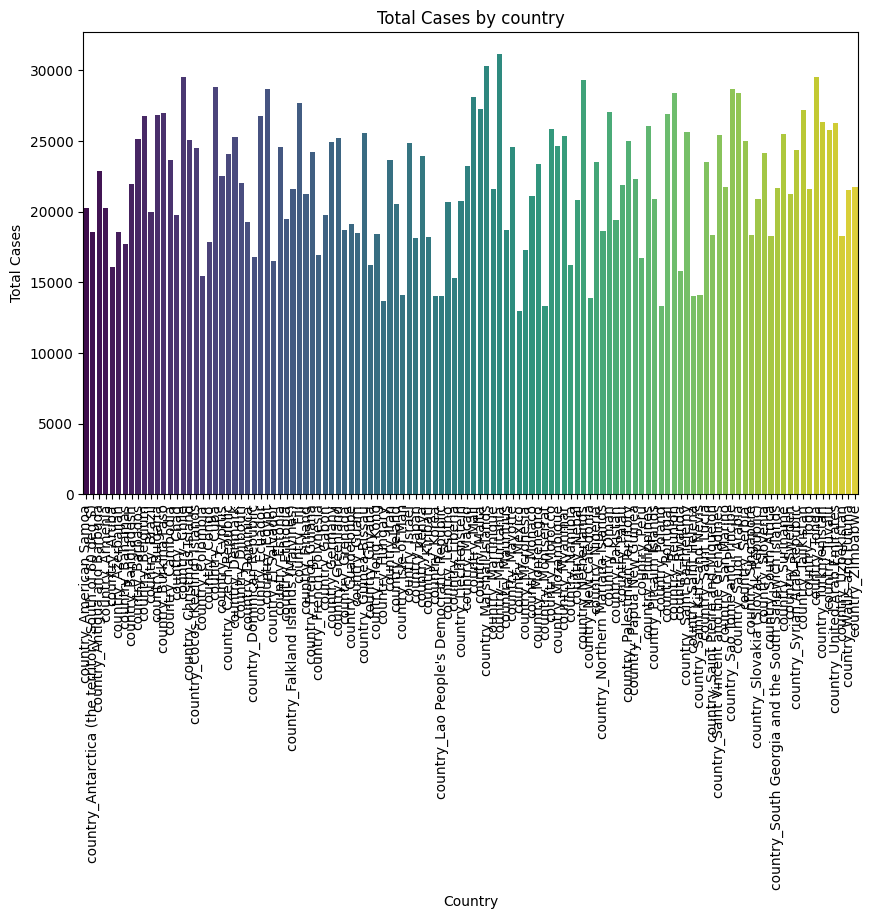

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Total Cases', data=country_cases, palette='viridis')
plt.title('Total Cases by country')
plt.xlabel('Country')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.show()

/tmp/ipython-input-13-4050754346.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='Total Cases', data=region_cases, palette='viridis')


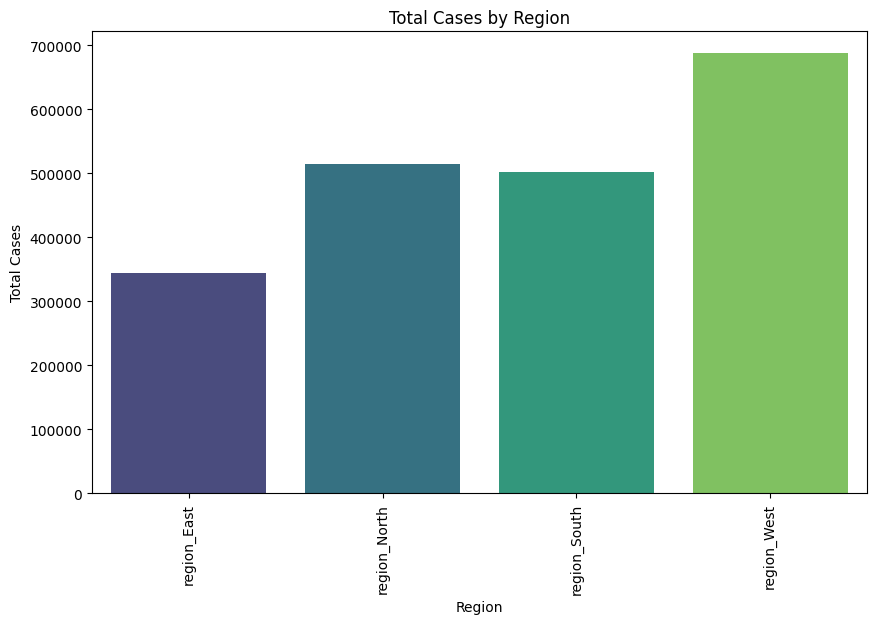

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Total Cases', data=region_cases, palette='viridis')
plt.title('Total Cases by Region')
plt.xlabel('Region')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.show()

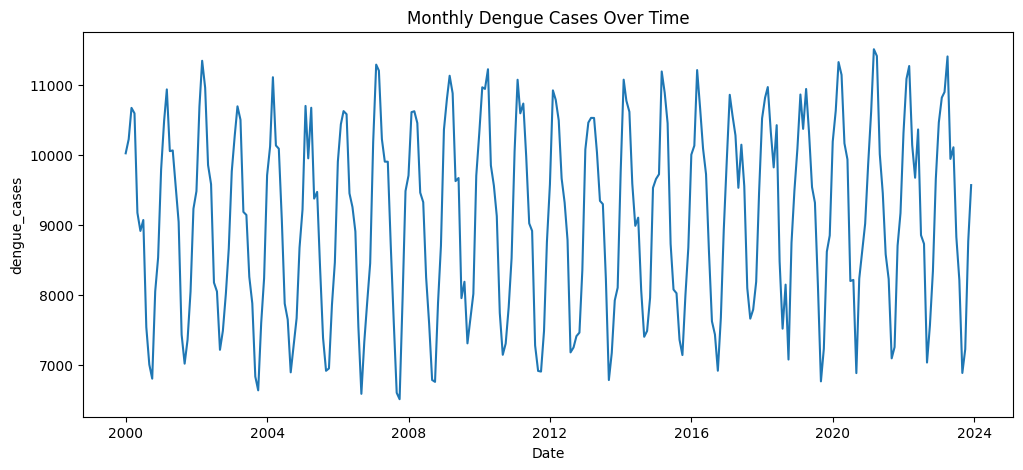

In [ ]:
monthly = df.groupby(['year', 'month'])['dengue_cases'].sum().reset_index()
monthly['Date'] = pd.to_datetime(monthly[['year', 'month']].assign(DAY=1))

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x='Date', y='dengue_cases')
plt.title("Monthly Dengue Cases Over Time")
plt.show()

## **FEATURE ENGINEERING**

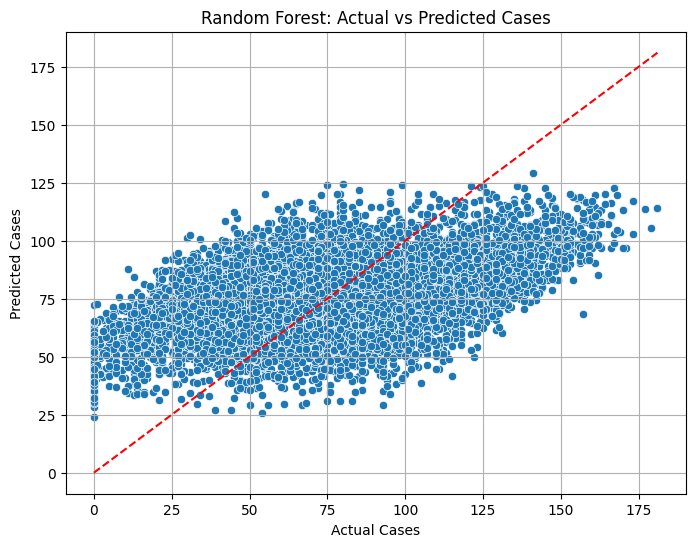

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # ideal line
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Random Forest: Actual vs Predicted Cases")
plt.grid(True)
plt.show()

## **COMPARE PROVINCE CASES TO FACTORS**

In [ ]:
df['Prov'] = df[province_columns].idxmax(axis=1).str.replace('Province_', '')
factors = df.groupby('Prov')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Prov', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Prov', y='Average Value', hue='Factor', palette='viridis')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

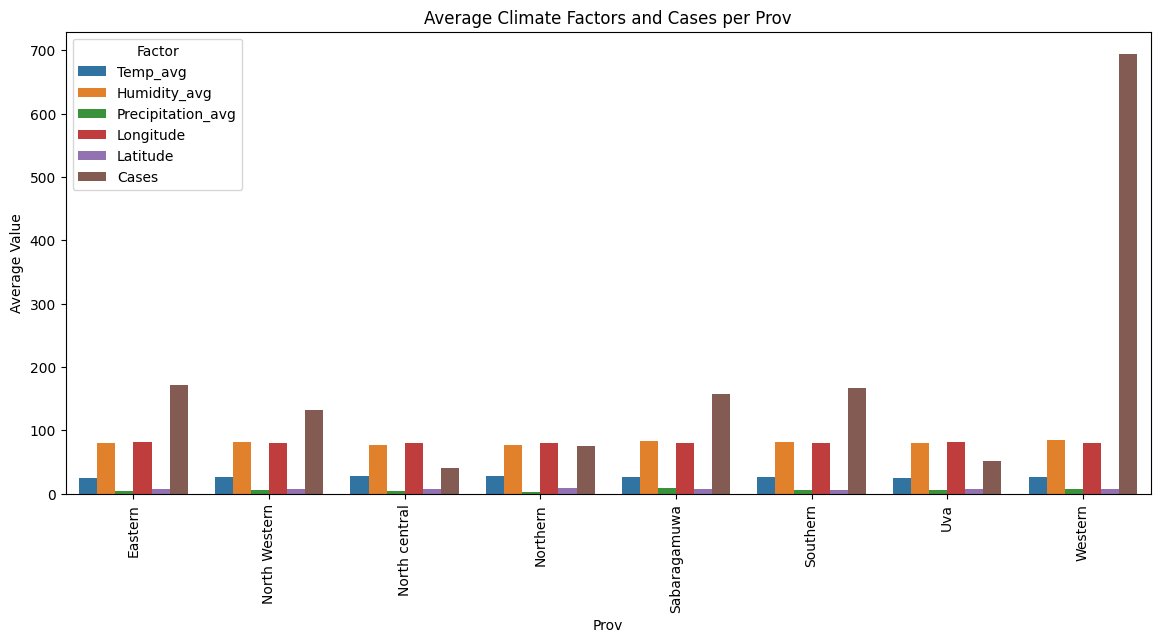

In [ ]:
df['Prov'] = df[province_columns].idxmax(axis=1).str.replace('Province_', '')
factors = df.groupby('Prov')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Longitude', 'Latitude', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Prov', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Prov', y='Average Value', hue='Factor', palette='tab10')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

### **COMPARE DISTRICT CASES TO FACTORS**

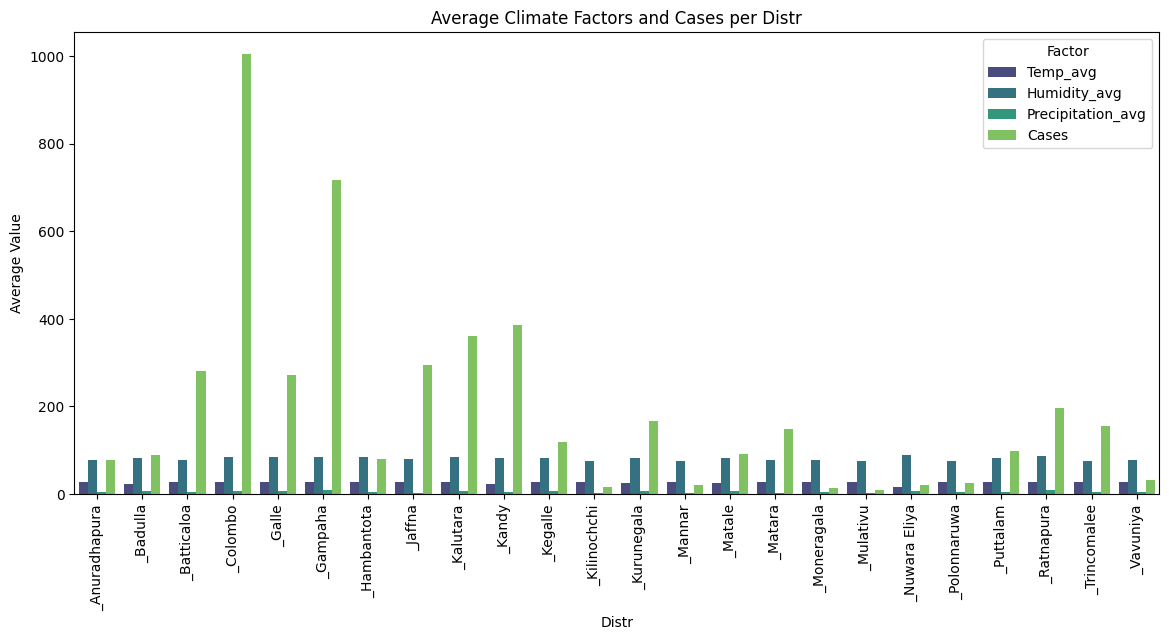

In [ ]:
df['Distr'] = df[district_columns].idxmax(axis=1).str.replace('District', '')
factors = df.groupby('Distr')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Distr', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Distr', y='Average Value', hue='Factor', palette='viridis')
plt.title('Average Climate Factors and Cases per Distr')
plt.xticks(rotation=90)
plt.show()

### **CORRELATION HEATMAP**

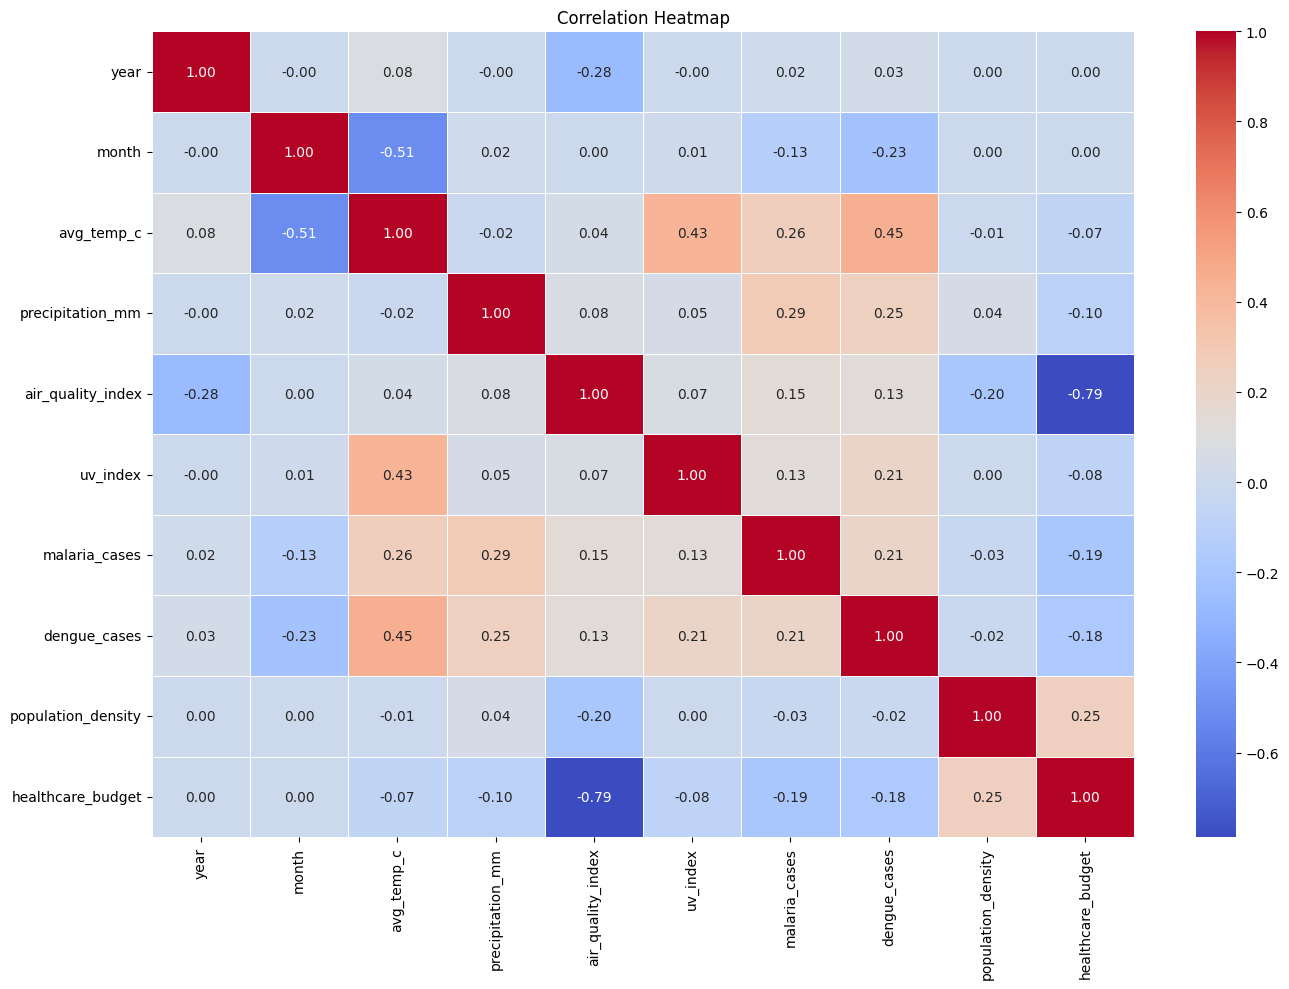

In [ ]:
df_corr = df.copy()
df_corr = pd.get_dummies(df_corr, drop_first=True)
df_corr = df_corr.select_dtypes(include='number')  # Keep only numeric columns

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# 1. Select your predictor and target
X = df[['avg_temp_c']]  # Predictor: average temperature
y = df['dengue_cases']  # Target: dengue cases

# 2. Add a constant term for the intercept
X = sm.add_constant(X)

# 3. Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X).fit()

# 4. Print the summary for p-value, R-squared, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           dengue_cases   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     8837.
Date:                Tue, 08 Jul 2025   Prob (F-statistic):               0.00
Time:                        19:38:14   Log-Likelihood:            -1.7020e+05
No. Observations:               34560   AIC:                         3.404e+05
Df Residuals:                   34558   BIC:                         3.404e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.0995      0.470     74.687      0.0

Results above for p value is <0.05 so temperature is a factor

### **----------START MODELLING-----------**

### **FEATURE IMPORTANCE**


In [ ]:
X = df.drop(columns=["dengue_cases"])
Y = df["dengue_cases"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                 Feature  Importance
2             avg_temp_c       0.307
3       precipitation_mm       0.164
4      air_quality_index       0.087
6          malaria_cases       0.086
0                   year       0.067
..                   ...         ...
39      country_Ethiopia       0.000
37   country_El Salvador       0.000
95   country_Philippines       0.000
75        country_Mexico       0.000
113     country_Slovenia       0.000

[132 rows x 2 columns]


### **RANDOM FOREST**

In [ ]:
regions = [ col for col in df.columns if col.startswith('region_')]


features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget', *regions]
X = df[features]
Y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.260345894527959
Mean Squared Error: 1058.229085011574


In [46]:
df = df.sort_values(by=['country', 'region', 'year', 'month']).reset_index(drop=True)

# ---- Create Lagged Features ----
df['dengue_cases_lag1'] = df['dengue_cases'].shift(1)
df['avg_temp_c_lag1'] = df['avg_temp_c'].shift(1)
df['precipitation_mm_lag1'] = df['precipitation_mm'].shift(1)
df['malaria_cases_lag1'] = df['malaria_cases'].shift(1)

# ---- Drop rows with NaNs from lagging (usually first row) ----
df = df.dropna().reset_index(drop=True)

# ---- Create Feature Interactions ----
df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
df['malaria_dengue_lag_interaction'] = df['malaria_cases_lag1'] * df['dengue_cases_lag1']
df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
df['healthcare_burden_index'] = df['population_density'] / (df['healthcare_budget'] + 1)
df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

# ---- Define Region Columns ----
regions = [col for col in df.columns if col.startswith('region_')]

# ---- Final Feature List ----
features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index', 'malaria_cases',
    'year', 'uv_index', 'population_density', 'healthcare_budget',
    'dengue_cases_lag1', 'avg_temp_c_lag1', 'precipitation_mm_lag1', 'malaria_cases_lag1',
    'temp_precip_interaction', 'malaria_dengue_lag_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction',
    'healthcare_burden_index', 'env_stress_score', *regions
]

# ---- Train-Test Split: Time-aware ----
split_index = int(0.8 * len(df))
X = df[features]
y = df['dengue_cases']
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# ---- Model Training ----
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ---- Predictions and Evaluation ----
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")


R-squared: 0.18118604022874474
Mean Squared Error: 1071.8564821198831


### **LGBM**

In [62]:
regions = [ col for col in df.columns if col.startswith('region_')]
# df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
# df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
# df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
# df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features] = scaler.fit_transform(X_train[features])
X_test_scaled[features] = scaler.transform(X_test[features])

# X = df[features]
# Y = df['dengue_cases']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1476
[LightGBM] [Info] Number of data points in the train set: 27358, number of used features: 13
[LightGBM] [Info] Start training from score 75.869508
R-squared: 0.2749112968389429
Mean Squared Error: 1013.2955023192278


### **GRADIENT BOOSTING REGRESSOR**

In [50]:
features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget',*regions]
X = df[features]
Y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.279521621692142
Mean Squared Error: 1006.8526748174186


### **XG BOOST**

In [52]:
features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget',*regions]
X = df[features]
Y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.23324722051620483
Mean Squared Error: 1071.5201416015625


### **FACEBOOK PROPHET**

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vcoui8g/4rp23ybd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vcoui8g/99b52aak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13922', 'data', 'file=/tmp/tmp6vcoui8g/4rp23ybd.json', 'init=/tmp/tmp6vcoui8g/99b52aak.json', 'output', 'file=/tmp/tmp6vcoui8g/prophet_modelgrk_ug59/prophet_model-20250708205554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   yhat  yhat_lower  yhat_upper
292 2024-08-01 72.217      26.282     114.986
293 2024-09-01 69.428      25.690     118.974
294 2024-10-01 69.627      24.875     114.625
295 2024-11-01 73.950      31.888     118.751
296 2024-12-01 82.007      35.409     127.623


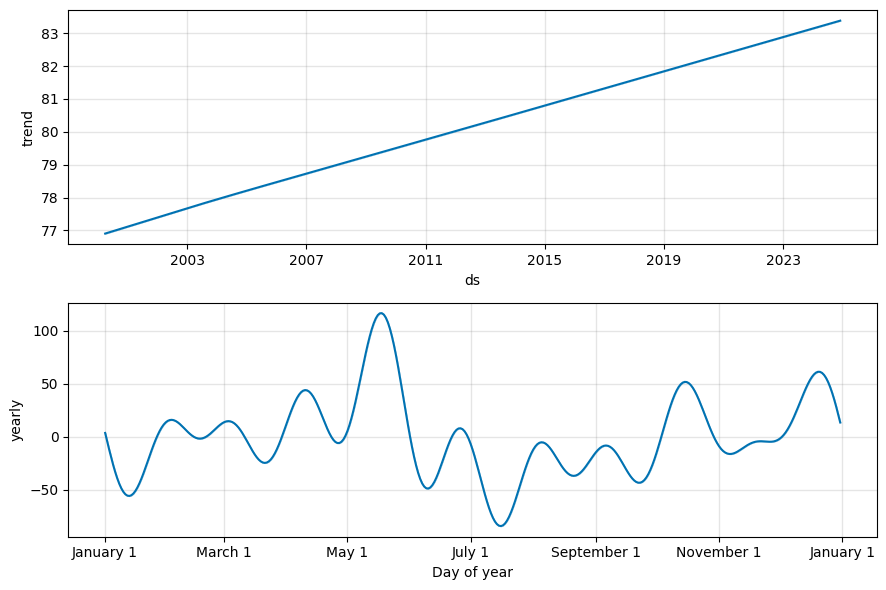

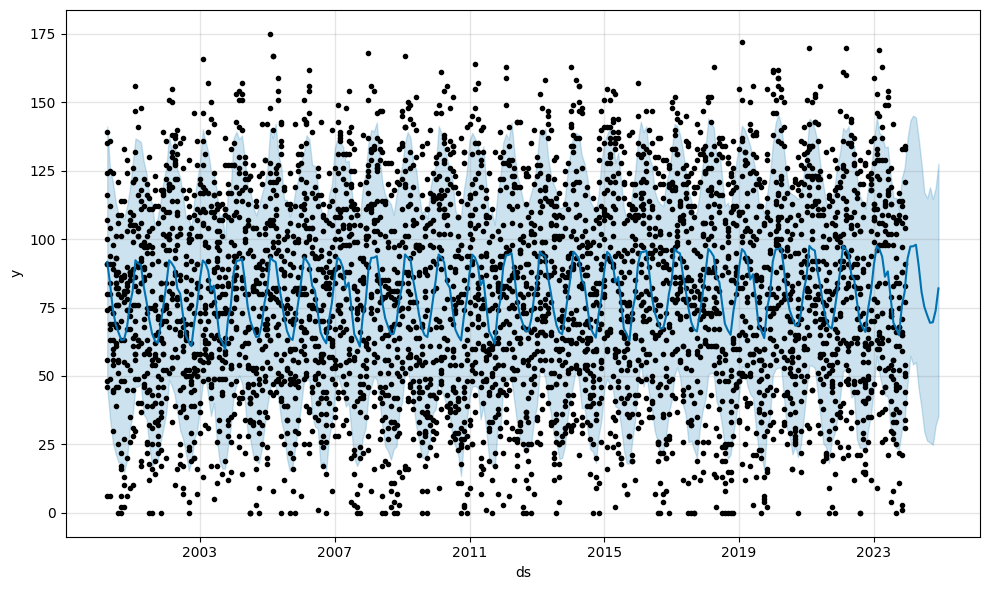

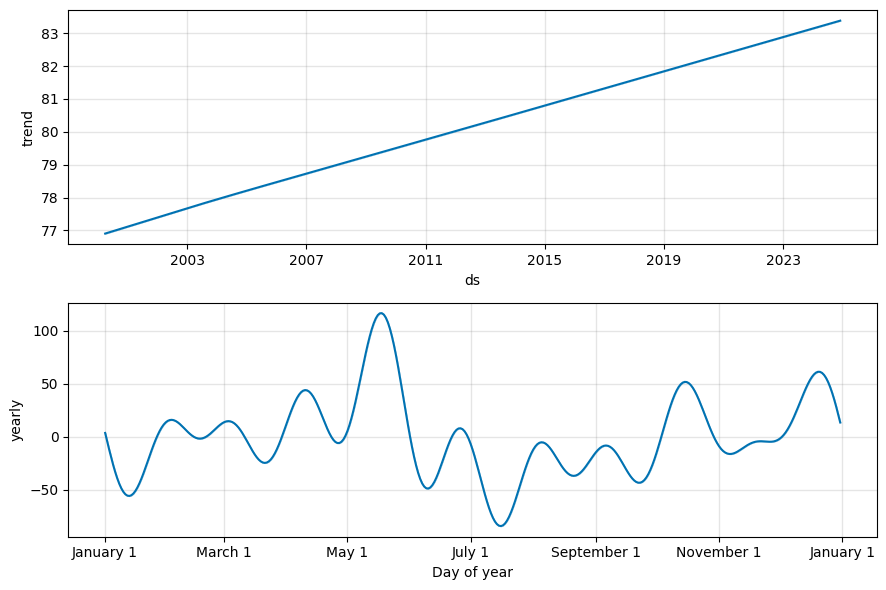

In [60]:
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values(by='ds')

regions = [col for col in df.columns if col.startswith('region_')]
df_prophet = df[['ds', 'dengue_cases', 'country'] + regions].copy()
df_prophet = df_prophet.rename(columns={'dengue_cases': 'y'})

region_df = df_prophet[df_prophet['region_East'] == True].dropna(subset=['y'])


model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(region_df)

future = model.make_future_dataframe(periods=12, freq='MS')

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

model.plot(forecast)
model.plot_components(forecast)